TO COLLECT IMAGES USING OpenCV

In [3]:
import os
import time
import uuid
import cv2

In [4]:

IMAGES_PATH = os.path.join('Facedata','Faceimages')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

ANNOTATING THE IMAGES USING LABELME LIBRARY

Review dataset and building image loading function

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

LIMITING GPU GROWTH

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:

tf.config.list_physical_devices('GPU')

[]

LOAD IMAGE TO TENSORFLOW DATA PIPELINE

In [12]:

images = tf.data.Dataset.list_files('Facedata\\Faceimages\\*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'Facedata\\Faceimages\\2873dfe9-4100-11ee-aaec-e86f38638476.jpg'

In [14]:

def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:

images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[161, 154, 136],
        [159, 152, 134],
        [157, 150, 132],
        ...,
        [101, 107, 105],
        [112, 118, 118],
        [148, 154, 154]],

       [[158, 151, 132],
        [157, 150, 131],
        [155, 150, 130],
        ...,
        [ 99, 103, 104],
        [116, 120, 121],
        [123, 127, 128]],

       [[153, 147, 125],
        [154, 148, 126],
        [154, 149, 129],
        ...,
        [101, 105, 106],
        [105, 106, 108],
        [118, 119, 121]]

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

VIEWING RAW IMAGES WITH MATPLOTLIB

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:

plot_images = image_generator.next()

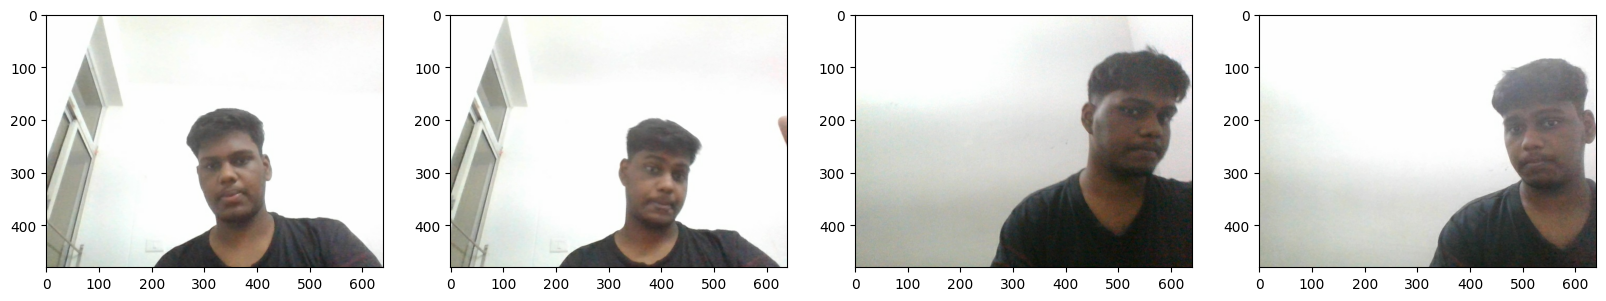

In [20]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

PARTITIONING UNAUGMENTED DATA

In [ ]:
## MANUALLY SPLITTING DATA INTO TRAIN AND TEST
## ASSIGNING 63 IMAGES TO TRAIN SET
## 14 to 13 images to val and test set respectively


MOVING TO MATCHING LABELS

In [26]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('Facedata', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('Facedata','Facelabels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('Facedata',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

APPLYING IMAGE AUGMENTATION ON IMAGES AND LABELS USING ALBUMENTATIONS

In [9]:
import albumentations as alb

In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))


LOADING THE TEST IMAGE

In [11]:
img = cv2.imread(os.path.join('Facedata','Train', 'images','82d7fa3d-4101-11ee-b7e9-e86f38638476.jpg'))
img

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[174, 188, 186],
        [175, 189, 187],
        [179, 193, 191],
        ...,
        [ 63,  50,  64],
        [ 66,  51,  65],
        [ 68,  53,  67]],

       [[169, 183, 179],
        [170, 184, 180],
        [177, 190, 188],
        ...,
        [ 67,  53,  65],
        [ 68,  51,  64],
        [ 68,  51,  64]],

       [[165, 179, 175],
        [166, 180, 176],
        [174, 187, 185],
        ...,
        [ 72,  56,  67],
        [ 69,  51,  64],
        [ 66,  48,  61]]

In [12]:
with open(os.path.join('Facedata', 'Train', 'labels', '82d7fa3d-4101-11ee-b7e9-e86f38638476.json'), 'r') as f:
    label = json.load(f)
label

{'version': '5.3.1',
 'flags': {},
 'shapes': [{'label': 'Face',
   'points': [[280.52631578947376, 100.52631578947368],
    [513.859649122807, 387.07602339181284]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\Faceimages\\82d7fa3d-4101-11ee-b7e9-e86f38638476.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8R

In [13]:
label['shapes'][0]['points']

[[280.52631578947376, 100.52631578947368],
 [513.859649122807, 387.07602339181284]]

EXTRACTING COORDINATES AND RESCALE TO MATCH IMAGE RESOUTION

In [14]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [15]:
coords

[280.52631578947376, 100.52631578947368, 513.859649122807, 387.07602339181284]

In [19]:
coords = list(np.divide(coords, [640,480,640,480]))

In [20]:
coords

[0.43832236842105277,
 0.20942982456140352,
 0.8029057017543859,
 0.8064083820662767]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [21]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [22]:

augmented['bboxes'][0][2:]

(1.0, 0.8010526315789473)

In [23]:
augmented['bboxes']

[(0.590058479532164, 0.1642755035737492, 1.0, 0.8010526315789473)]

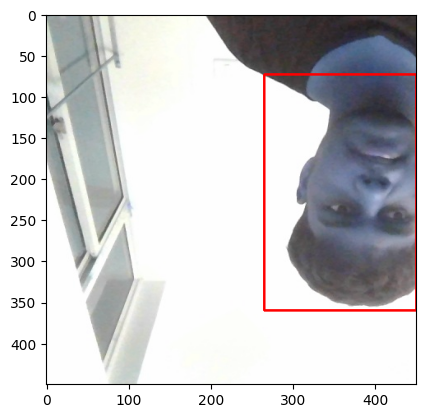

In [24]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [5]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt



In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('Facedata', partition, 'images')):
        img = cv2.imread(os.path.join('Facedata', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('Facedata', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])
                cv2.imwrite(os.path.join('Facedata','aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
               

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('Facedata','aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

LOADING AUGMENTED IMAGES TO TENSORFLOW DATASET

In [9]:


# Load and preprocess the image
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decoding JPEG images
    return image

# Load the file paths of images in the dataset
train_images = tf.data.Dataset.list_files('Facedata\\aug_data\\train\\images\\*.jpg', shuffle=False)

# Map the image loading function to the dataset
train_images = train_images.map(load_image)

# Resize the images to a specific size
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))

# Normalize the pixel values of images
train_images = train_images.map(lambda x: x / 255)


In [10]:

test_images = tf.data.Dataset.list_files('Facedata\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [11]:
val_images = tf.data.Dataset.list_files('Facedata\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [12]:
train_images.as_numpy_iterator().next()

array([[[0.5449142 , 0.53817403, 0.5876838 ],
        [0.5321691 , 0.52824754, 0.5880515 ],
        [0.5323529 , 0.5328431 , 0.58688724],
        ...,
        [0.7240196 , 0.79313725, 0.8509804 ],
        [0.7159926 , 0.7898284 , 0.8463848 ],
        [0.71666664, 0.7911765 , 0.847549  ]],

       [[0.53903186, 0.5403186 , 0.57959557],
        [0.5409926 , 0.5411152 , 0.58817405],
        [0.5377451 , 0.54558825, 0.5926471 ],
        ...,
        [0.7456495 , 0.81329656, 0.8833946 ],
        [0.7396446 , 0.8098652 , 0.8872549 ],
        [0.7393995 , 0.8173407 , 0.8884191 ]],

       [[0.5384191 , 0.5511642 , 0.5957721 ],
        [0.5420343 , 0.54987746, 0.60085785],
        [0.5421569 , 0.55      , 0.6009804 ],
        ...,
        [0.7701593 , 0.8568627 , 0.9117647 ],
        [0.7788603 , 0.8612132 , 0.9278799 ],
        [0.7712622 , 0.8536152 , 0.93241423]],

       ...,

       [[0.56145835, 0.575674  , 0.608027  ],
        [0.56121325, 0.57297796, 0.60042894],
        [0.57598037, 0

PREAPAIRING LABELS

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [14]:
train_labels = tf.data.Dataset.list_files('Facedata\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('Facedata\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('Facedata\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.267 , 0.    , 0.7803, 0.4775], dtype=float16))

COMBINING LABEL AND IMAGE SAMPLES

In [15]:
# Checking partition lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 840, 840)

In [16]:
#CREATING FINAL DATASETS
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1965, 0.1315, 0.711 , 0.599 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1777, 0.2988, 0.587 , 0.988 ],
        [0.2686, 0.2303, 0.87  , 0.7554],
        [0.5684, 0.0583, 0.917 , 0.5806],
        [0.901 , 0.3442, 1.    , 1.    ],
        [0.736 , 0.2588, 1.    , 0.7993],
        [0.1398, 0.1512, 0.8037, 0.7427]], dtype=float16))

VIEWING IMAGES AND ANNOTATIONS

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


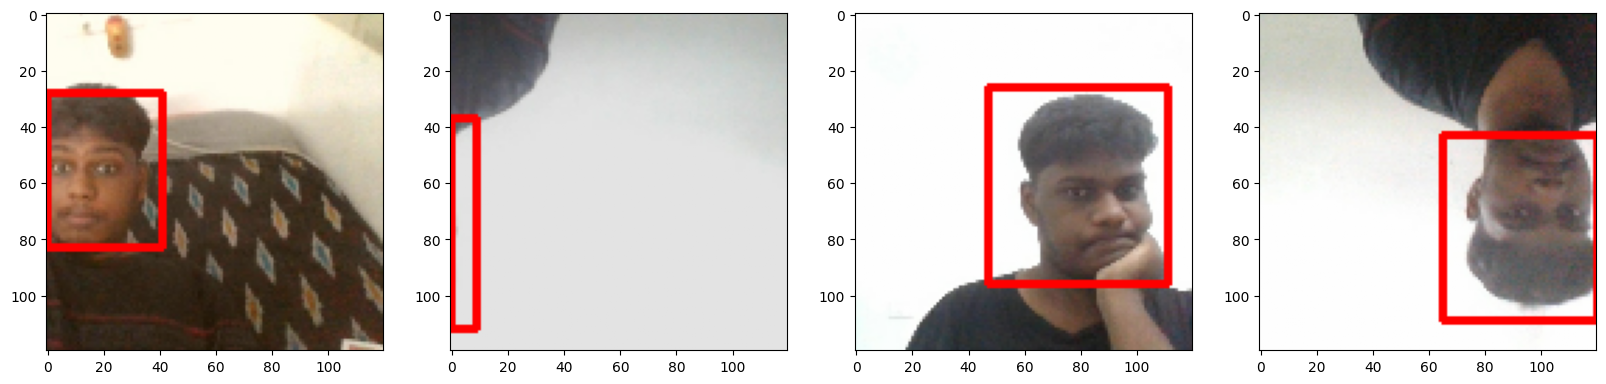

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

BUILDING DEEP LEARNING USING A FUNCIONAL API

In [20]:

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16




In [21]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [22]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Testing out the neural network

In [23]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [24]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [25]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 1s 882ms/step


(array([[0.43402618],
        [0.42178696],
        [0.35187826],
        [0.4309588 ],
        [0.41178095],
        [0.3237965 ],
        [0.3569326 ],
        [0.3859451 ]], dtype=float32),
 array([[0.60293895, 0.58792454, 0.5395586 , 0.3766189 ],
        [0.6531799 , 0.51628554, 0.5673973 , 0.45154497],
        [0.68118805, 0.6297855 , 0.49390092, 0.4401121 ],
        [0.62601775, 0.55447376, 0.5520349 , 0.42644793],
        [0.64803416, 0.5581589 , 0.5181703 , 0.36338782],
        [0.60044867, 0.61015064, 0.5141673 , 0.38359156],
        [0.67079985, 0.62298644, 0.5751604 , 0.42841753],
        [0.6745282 , 0.48478672, 0.5557618 , 0.4658731 ]], dtype=float32))

DEFINING LOSSES AND OPTIMIZERS

In [37]:
len(train)

473

In [39]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [27]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [28]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [29]:
# TESTING OUT LOSS METRICS
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.120954>

In [30]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.94766104>

In [31]:

regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.120954>

TRAINING THE NEURAL NETWORK

In [32]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [33]:
model = FaceTracker(facetracker)

In [40]:
model = FaceTracker(facetracker)
model.compile( opt, classloss, regressloss)

In [41]:
#TRAIN
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 971s 2s/step - total_loss: 0.3069 - class_loss: 0.0481 - regress_loss: 0.2829 - val_total_loss: 0.6282 - val_class_loss: 0.1433 - val_regress_loss: 0.5565
Epoch 2/10
473/473 [==============================] - 948s 2s/step - total_loss: 0.1315 - class_loss: 0.0240 - regress_loss: 0.1195 - val_total_loss: 0.2016 - val_class_loss: 7.7160e-04 - val_regress_loss: 0.2012
Epoch 3/10
473/473 [==============================] - 882s 2s/step - total_loss: 0.1133 - class_loss: 0.0252 - regress_loss: 0.1007 - val_total_loss: 0.6328 - val_class_loss: 0.2300 - val_regress_loss: 0.5178
Epoch 4/10
473/473 [==============================] - 890s 2s/step - total_loss: 0.0869 - class_loss: 0.0185 - regress_loss: 0.0776 - val_total_loss: 0.1550 - val_class_loss: 0.0287 - val_regress_loss: 0.1406
Epoch 5/10
473/473 [==============================] - 881s 2s/step - total_loss: 0.0746 - class_loss: 0.0169 - regress_loss: 0.0662 - val_total_loss: 0.1104 - v

In [42]:
hist.history

{'total_loss': [0.03521418944001198,
  0.023341849446296692,
  0.01586247980594635,
  0.019047392532229424,
  0.011614937335252762,
  0.00830483715981245,
  0.0066692461259663105,
  0.01104991789907217,
  0.002694887574762106,
  0.005375598091632128],
 'class_loss': [0.00015359118697233498,
  7.49531955079874e-06,
  0.00014495241339318454,
  3.369371552253142e-05,
  2.2665095457341522e-05,
  3.205327084288001e-05,
  0.0003111235855612904,
  0.005836697295308113,
  4.0829313547874335e-06,
  3.118899985565804e-05],
 'regress_loss': [0.035137392580509186,
  0.02333810180425644,
  0.015790004283189774,
  0.01903054490685463,
  0.01160360500216484,
  0.008288810960948467,
  0.006513684522360563,
  0.008131569251418114,
  0.002692846115678549,
  0.005360003560781479],
 'val_total_loss': [0.6281506419181824,
  0.2016177773475647,
  0.6327890753746033,
  0.1549685001373291,
  0.11043091118335724,
  0.17810603976249695,
  0.14681465923786163,
  0.45571383833885193,
  0.4740622937679291,
  0.181

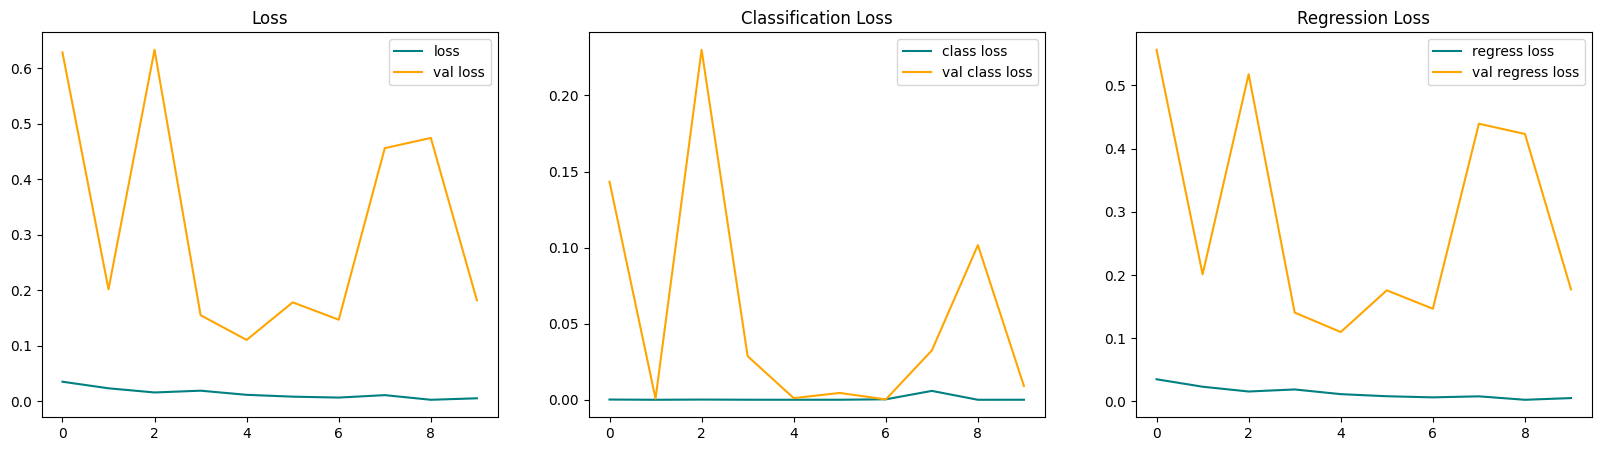

In [43]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [44]:
#MAKING PREDICTION
test_data = test.as_numpy_iterator()

In [45]:
test_sample = test_data.next()

In [46]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 389ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


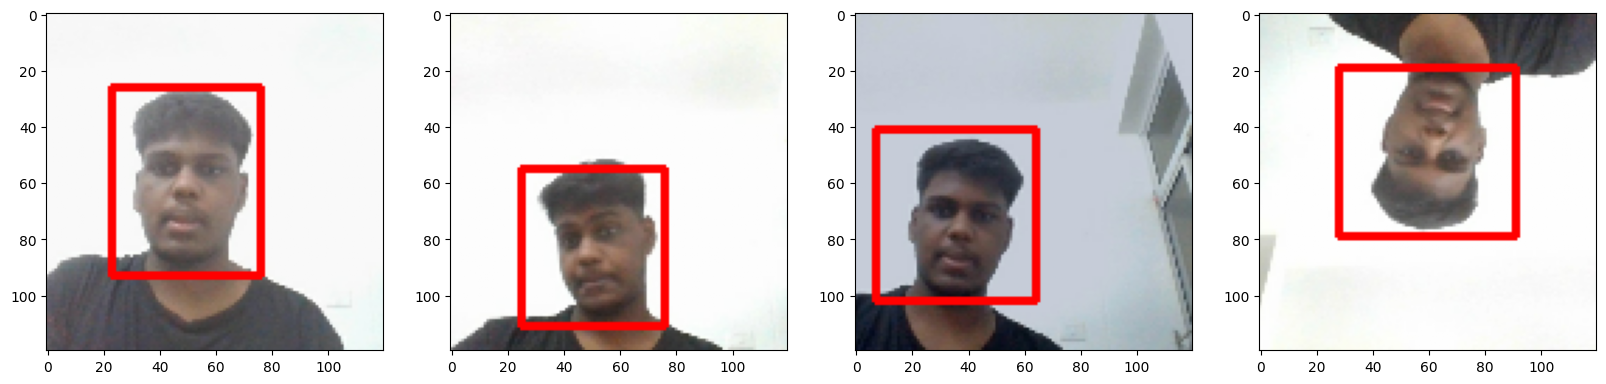

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

SAVING THE MODEL

In [48]:
from keras.models import load_model

In [49]:

facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

c:\Users\rishi\Desktop\SOL\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


REAL TIME TEST

In [53]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    if not _:
        print("Failed to capture frame")
        break
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.namedWindow("EyeTrack", cv2.WINDOW_NORMAL)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
